# Debugging instability new configuration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import glob
import netCDF4 as nc
import sys
import tqdm
sys.path.append('/home/users/birgal/')
from nemo_python.ics_obcs import vertical_edges

In [3]:
file = 'ANHA12-EXH006_y2015m05d10_icemod.nc'
file.split('ANHA12-EXH006_')[1].split('_')[0]

'y2015m05d10'

### Vertical interpolation of initial conditions debugging and fixing

In [82]:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    
    NEMO_top_edge = nemo_edges[0][n,:,:]; NEMO_bot_edge = nemo_edges[2][n,:,:];

    dataset = xr.Dataset({}) #.assign_coords(x=source.x, y=source.y)

    for var in source: # loop over the variables in the source dataset
        # find the source edges that fall within the depth ranges of the NEMO grid cells:
        # the weighting doesn't quite work right yet to make it conservative
        Var_total = np.zeros(NEMO_top_edge.shape); 
        for zs in range(0,source.z.size):
            src_top_edge = source_edges[0][zs,:,:]; src_bot_edge = source_edges[2][zs,:,:];

            # NEMO cells that fall fully within the SOSE cell:
            Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge <= src_bot_edge), \
                           source.isel(z=zs)*(NEMO_bot_edge - NEMO_top_edge), 0)
        
            # NEMO cells that have an overlap at the bottom: 
            Var = xr.where((NEMO_top_edge <= src_bot_edge)*(NEMO_bot_edge >= src_bot_edge)*(NEMO_top_edge >= src_top_edge), \
                           source.isel(z=zs)*(src_bot_edge - NEMO_top_edge), Var)
        
            # NEMO cells that have an overlap at the top:
            Var = xr.where((NEMO_top_edge < src_top_edge)*(NEMO_bot_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), \
                           source.isel(z=zs)*(NEMO_bot_edge - src_top_edge), Var)

            # SOSE cell smaller than NEMO cell and fully encapsulated:
            Var = xr.where((NEMO_top_edge <= src_bot_edge)*(NEMO_bot_edge >= src_bot_edge)*(NEMO_top_edge < src_top_edge)*(NEMO_bot_edge <= np.max(source_edges[2])), \
                           Var + source.isel(z=zs)*(src_bot_edge - src_top_edge), Var)

            # NEMO cells that have an overlap at the top and then nothing below that (bottom):
            # Var = xr.where((NEMO_top_edge <= src_bot_edge)*(NEMO_bot_edge >= src_bot_edge)*(NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge > np.max(source_edges[2])), \
            #                source.isel(z=zs)*(NEMO_bot_edge - NEMO_top_edge), Var)
            
            # Cell at the bottom of each column:
            # Var = xr.where((NEMO_top_edge < src_top_edge)*(NEMO_bot_edge >= src_bot_edge)*(NEMO_bot_edge > np.max(source_edges[2])),\
            #                Var + source.isel(z=zs)*(NEMO_bot_edge - src_bot_edge), Var)

            Var_total += Var

        Var_total = xr.where((NEMO_bot_edge > np.max(source_edges[2][~np.isnan(source[var])], axis=0)), \
                              np.nan, Var_total) 
        
        Var_total = Var_total/(NEMO_bot_edge - NEMO_top_edge)
        
        dataset[var] = (('y', 'x'), Var_total[var].values)

    return dataset

In [2]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025-filledlakes.nc')

In [3]:
hinterp_var = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-horizontal-interp.nc')

In [83]:
# source_coord = hinterp_var.assign(drF=(['z'], SOSE_coord.drF.values))
# source_edges = vertical_edges(source_coord.isel(y=slice(300,440), x=slice(1000,1200)), mtype='SOSE')
# nemo_edges   = vertical_edges(mesh.isel(y=slice(300,440), x=slice(1000,1200)), mtype='nemo')

# model_ICs = []
# for n in tqdm.tqdm(range(len(mesh.nav_lev.values))):
#     data_interp = interp_depth(hinterp_var.isel(y=slice(300,440), x=slice(1000,1200)), source_edges, nemo_edges, n)        
#     model_ICs.append(data_interp) # Add interpolated layers to dataset
    
# source_interp = xr.concat(model_ICs, dim='z') 

source_coord = hinterp_var.assign(drF=(['z'], SOSE_coord.drF.values))
source_edges = vertical_edges(source_coord, mtype='SOSE')
nemo_edges   = vertical_edges(mesh, mtype='nemo')

model_ICs = []
for n in tqdm.tqdm(range(len(mesh.nav_lev.values))):
    data_interp = interp_depth(hinterp_var, source_edges, nemo_edges, n)        
    model_ICs.append(data_interp) # Add interpolated layers to dataset
    
source_interp = xr.concat(model_ICs, dim='z') 

100%|██████████| 121/121 [06:24<00:00,  3.18s/it]


In [73]:
# print(source_interp.SALT.sel(x=1050, y=382))
# print(hinterp_var.SALT.sel(x=1050, y=382))
print(source_interp.SALT.sel(x=50, y=82))
print(hinterp_var.SALT.sel(x=50, y=82))
# ---> the exception in this case occurs because the cell is only partially deeper than the deepest SOSE cell.
# so, in that case, it should multiply by (NEMO_bot - NEMO_top) instead of the diff between SOSE and NEMO

<xarray.DataArray 'SALT' (z: 121)>
array([33.06767194, 33.06767194, 33.06767194, 33.06858987, 33.07197466,
       33.07197466, 33.07197466, 33.13876821, 33.14631419, 33.16406858,
       33.36049098, 33.36049098, 33.6027692 , 33.72084527, 33.85694526,
       34.03838852, 34.13610932, 34.24558511, 34.34640686, 34.40563475,
       34.4692048 , 34.53439908, 34.5934818 , 34.64421567, 34.6893772 ,
       34.7276658 , 34.75473484, 34.77629152, 34.79203111, 34.80298211,
       34.81340547, 34.82390036, 34.83080079, 34.8374923 , 34.84504738,
       34.85061897, 34.85477301, 34.85850699, 34.86188427, 34.86524653,
       34.86577617, 34.86922225, 34.86923707, 34.87118096, 34.87220958,
       34.87220958, 34.87438348, 34.87461434, 34.87461434, 34.8761725 ,
       34.87640505, 34.87640505, 34.87735518, 34.87751728, 34.87751728,
       34.87784799, 34.87800553, 34.87800553, 34.87800553, 34.87796363,
       34.87790193, 34.87790193, 34.87790193, 34.87790193, 34.87790193,
       34.87749534, 34.877236

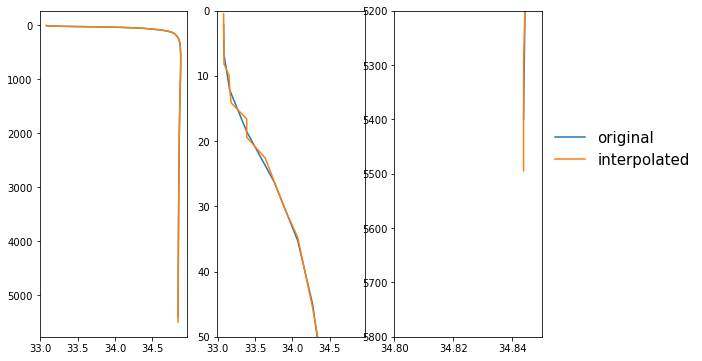

In [78]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(hinterp_var.SALT.sel(x=1050, y=383)  , SOSE_cent, label='original')
    axis.plot(source_interp.SALT.sel(x=1050, y=383), NEMO_cent, label='interpolated')

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)

ax[2].legend(fontsize=15, frameon=False, loc=(1.05, 0.5))
## temperature looks normal

(5800.0, 5200.0)

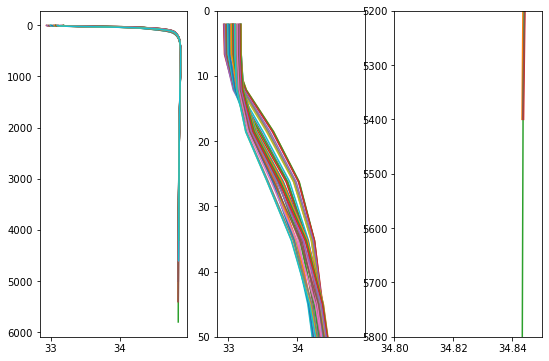

In [79]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    y_coord = np.arange(360,400)
    for yc in y_coord:
        axis.plot(hinterp_var.SALT.sel(x=1050, y=yc)  , SOSE_cent) # original

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)

# ax[2].legend(fontsize=15, frameon=False, loc=(1.05, 0.5))
## temperature looks normal

(5800.0, 5200.0)

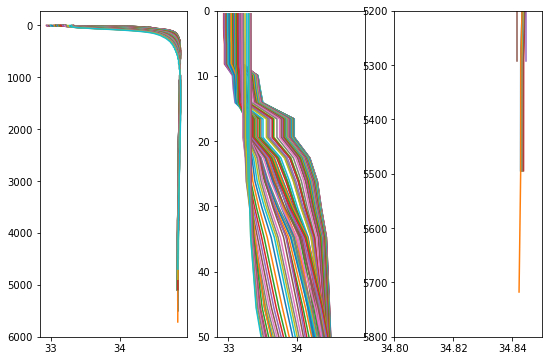

In [85]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    # for yc in np.arange(382, 383):
    for yc in np.arange(320, 430):
        axis.plot(source_interp.SALT.sel(x=1050, y=yc)  , NEMO_cent) # interpolated
    # axis.plot(source_interp.SALT.sel(x=1050, y=382)  , NEMO_cent) # interpolated

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)

# ax[2].legend(fontsize=15, frameon=False, loc=(1.05, 0.5))
## temperature looks normal

In [81]:
# Find vertical cell edges
SOSE_coord      = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc')
SOSE_coord['Z'] = abs(SOSE_coord['Z'])
SOSE_coord      = SOSE_coord.rename({'Z':'z'})
(z_top_edge, z_centres, z_bot_edge)          = vertical_edges(SOSE_coord, mtype='SOSE')
(nemo_top_edge, nemo_centres, nemo_bot_edge) = vertical_edges(mesh, mtype='nemo')

Let's focus the debugging/testing on cell x=1050, y=383:

In [8]:
SOSE_top = z_top_edge[:,0,0]        ; SOSE_bot = z_bot_edge[:,0,0]; SOSE_cent = z_centres[:,0,0];
NEMO_top = nemo_top_edge[:,382,1050]; NEMO_bot = nemo_bot_edge[:,411,1050]; NEMO_cent = nemo_centres[:,411,1050]

In [7]:
def plot_cond(ax, ind):
    ax[0]. plot([0.5], SOSE_cent[ind], '.m', markersize=20)
    
    NEMO_plot1 = np.ma.masked_where(~((NEMO_top >= SOSE_top[ind])*(NEMO_bot <= SOSE_bot[ind])), NEMO_cent)
    NEMO_plot2 = np.ma.masked_where(~((NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])), NEMO_cent)
    NEMO_plot3 = np.ma.masked_where(~((NEMO_top < SOSE_top[ind])*(NEMO_bot >= SOSE_top[ind])*(NEMO_bot < SOSE_bot[ind])), NEMO_cent)
    NEMO_plot4 = np.ma.masked_where(~((NEMO_top < SOSE_top[ind]) *(NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])), NEMO_cent)
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot1, '.r', markersize=25);
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot2, '.c', markersize=20);
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot3, '.b', markersize=10);
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot4, '.m', markersize=5);


    return

In [487]:
# Mask depth levels that are deeper than the ocean depth in this location
z_bot_edge[z_bot_edge > SOSE_coord.Depth.values] = np.nan
# But, this won't quite work because I have the ocean depth levels from SOSE on tNEMO_cond6 = (NEMO_top > np.max(SOSE_bot[~np.isnan(hinterp_var.isel(x=1050, y=383).SALT)]))he SOSE grid, not on the horizontal NEMO grid
# Instead should I just assume the whole cell was filled? Not quite conservative then...

Text(0.5, 1.0, 'NEMO')

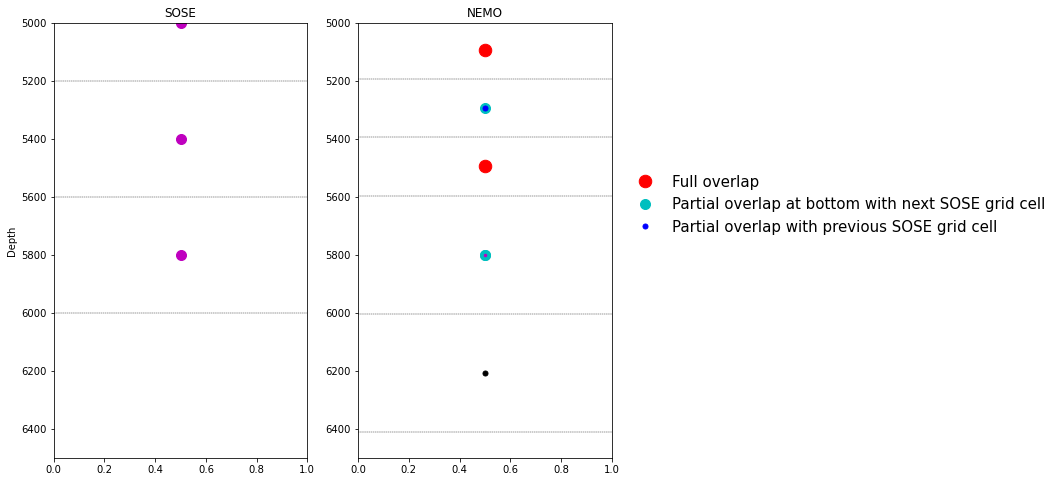

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10,8))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_xlim(0, 1)
    axis.set_ylim(6500, 5000)
    
# SOSE:
[ax[0].plot([0, 1], [layer, layer], '--k', linewidth=0.4) for layer in SOSE_top]
ax[0].plot([0, 1], [SOSE_bot[-1], SOSE_bot[-1]], '--k', linewidth=0.4)
ax[0]. plot(0.5*np.ones(SOSE_cent.shape), SOSE_cent, '.k', markersize=10)
ax[0].set_title('SOSE')
ax[0].set_ylabel('Depth')

# NEMO:
[ax[1].plot([0, 1], [layer, layer], '--k', linewidth=0.4) for layer in NEMO_top]
ax[1]. plot(0.5*np.ones(NEMO_cent.shape), NEMO_cent, '.k', markersize=10)
ax[1].plot([0, 1], [NEMO_bot[-1], NEMO_bot[-1]], '--k', linewidth=0.4)

ax[1].plot([-0.5],[-0.5], '.r', markersize=25, label='Full overlap');
ax[1].plot([-0.5],[-0.5], '.c', markersize=20, label='Partial overlap at bottom with next SOSE grid cell');
ax[1].plot([-0.5],[-0.5], '.b', markersize=10, label='Partial overlap with previous SOSE grid cell');

for ind, cent in enumerate(SOSE_cent):
    plot_cond(ax, ind)

    NEMO_plot4 = np.ma.masked_where(~((SOSE_bot[ind] > np.max(NEMO_bot))*(SOSE_bot[ind] > NEMO_bot)*(SOSE_top[ind] < NEMO_top)), NEMO_cent)
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot4, '.k', markersize=10);

plot_cond(ax, 0)
# plot_cond(ax, 1)
ax[0].plot([0.75], [NEMO_cent[24]], '.k', markersize=20)

ax[1].legend(loc=(1.05, 0.5), frameon=False, fontsize=15)
ax[1].set_title('NEMO')

In [52]:
print(*zip(SOSE_top[51:52], SOSE_bot[51:52]))
print(hinterp_var.isel(z=slice(51,52), x=1050, y=382).SALT.values)
print((Var_total/(NEMO_bot - NEMO_top))[-2:])
print(*zip(NEMO_top[-2:], NEMO_bot[-2:]))

(5600.0, 6000.0)
[34.84336293]
[15.71815912         nan]
(5595.5532510978765, 6003.539351044795) (6003.539351044795, 6411.525450991713)


In [9]:
Var_total = np.zeros(NEMO_top.shape)

for ind in range(0,52):
    SOSE_salt = hinterp_var.isel(z=ind, x=1050, y=411).SALT.values
    
    NEMO_cond1 = (NEMO_top >= SOSE_top[ind])*(NEMO_bot <= SOSE_bot[ind])
    NEMO_cond2 = (NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])*(NEMO_top >= SOSE_top[ind])
    NEMO_cond3 = (NEMO_top < SOSE_top[ind]) *(NEMO_bot >= SOSE_top[ind])*(NEMO_bot < SOSE_bot[ind]) 
    NEMO_cond4 = (NEMO_top < SOSE_top[ind]) *(NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])   
    NEMO_cond5 = (NEMO_top < SOSE_top[ind]) *(NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])*(NEMO_bot > np.max(SOSE_bot)) # has overlap with bottom grid cell   
    # NEMO_cond5 = (SOSE_bot[ind] > np.max(NEMO_bot, axis=0))*(SOSE_bot[ind] > NEMO_bot)*(SOSE_top[ind] < NEMO_top)
    # if there is a nemo grid cell that is deeper than any SOSE grid cell, fill with NaN to be filled later by fill_ocean:
    NEMO_cond6 = (NEMO_top > np.max(SOSE_bot[~np.isnan(hinterp_var.isel(x=1050, y=411).SALT)]))
    
    Var = xr.where(NEMO_cond1, SOSE_salt*(NEMO_bot - NEMO_top)     , 0)
    Var = xr.where(NEMO_cond2, SOSE_salt*(SOSE_bot[ind] - NEMO_top), Var)
    Var = xr.where(NEMO_cond3, SOSE_salt*(NEMO_bot - SOSE_top[ind]), Var) 
    Var = xr.where(NEMO_cond4, Var + SOSE_salt*(SOSE_bot[ind] - SOSE_top[ind]), Var) # full SOSE cell fits in NEMO cell that is bigger 
    Var = xr.where(NEMO_cond5, Var + SOSE_salt*(NEMO_bot - SOSE_bot[ind]), Var)
    Var = xr.where(NEMO_cond6, np.nan, Var)
    
    Var_total += Var
    
print(Var_total/(NEMO_bot - NEMO_top))

[33.21674541 33.21674541 33.21674541 33.21727983 33.21925043 33.21925043
 33.21925043 33.22718741 33.22808409 33.23009594 33.25235368 33.25235368
 33.32296126 33.35737238 33.4473403  33.56728206 33.67113092 33.78747194
 33.92854679 34.01820034 34.1209398  34.22837884 34.32343816 34.40435146
 34.47860953 34.54636579 34.59844348 34.64235103 34.67639215 34.70072428
 34.72381682 34.7456195  34.75928586 34.77220374 34.78642069 34.79701274
 34.8050807  34.81250887 34.81945195 34.82733463 34.82857635 34.83800271
 34.83804325 34.84387084 34.84695455 34.84695455 34.85386606 34.85460003
 34.85460003 34.85980709 34.86058423 34.86058423 34.86428708 34.86491885
 34.86491885 34.86723025 34.86833139 34.86833139 34.86833139 34.8694341
 34.87105805 34.87105805 34.87105805 34.87105805 34.87105805 34.87198921
 34.87258113 34.87258113 34.87258113 34.87258113 34.87260781 34.87277973
 34.87277973 34.87277973 34.87277973 34.87264778 34.87215655 34.87215655
 34.87215655 34.87212139 34.87104583 34.87104583 34.

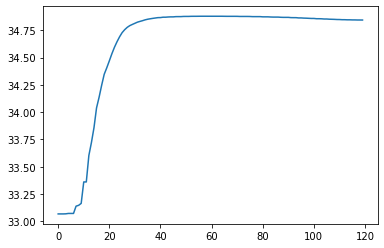

In [59]:
plt.plot(Var_total/(NEMO_bot - NEMO_top))

In [ ]:
34.84379278

In [61]:
print('Interpolated total', np.nansum((Var_total*mesh.e3t_0.isel(x=1050, y=382).values/(NEMO_bot - NEMO_top))))
print('Original total', np.nansum(hinterp_var.SALT.isel(x=1050,y=382)*SOSE_coord.drF))
# check if the difference is just because of my calculated edge locations

Interpolated total 209184.53511951235
Original total 209045.49686850328


In [379]:
print((Var_total*mesh.e3t_0.isel(x=1050, y=383)).isel(nav_lev=100).values)
print(Var_total[100], mesh.e3t_0.isel(x=1050, y=383).isel(nav_lev=100).values)

[548950.1277136]
4374.368751608471 [125.49242162]


In [368]:
print(np.nansum(mesh.e3t_0.isel(x=1050, y=383)))
print(np.nansum(SOSE_coord.drF))

5965.406081575895
6000.0


In [ ]:
# Loop over source cells:
for zs in range(0,source.z.size):
    src_top_edge = source_edges[0][zs,:,:]; src_bot_edge = source_edges[2][zs,:,:];

    # NEMO cells that fall fully within the SOSE cell:
    Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge <= src_bot_edge), \
                   Var + source.isel(z=zs)*(NEMO_bot_edge - NEMO_top_edge), Var)

    # NEMO cells that have an overlap at the bottom:
    Var = xr.where((NEMO_top_edge <= src_bot_edge)*(NEMO_bot_edge >= src_bot_edge), \
                   Var + source.isel(z=zs)*(src_bot_edge - NEMO_top_edge), Var)

    # NEMO cells that have an overlap at the top:
    Var = xr.where((NEMO_top_edge <= src_top_edge)*(NEMO_bot_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), \
                   Var + source.isel(z=zs)*(NEMO_bot_edge - src_top_edge), Var)

    # Cell at the very bottom:
    if (zs==(source.z.size-1)):
        if src_bot_edge > np.max(NEMO_bot_edge): # source depth goes deeper than NEMO, so transfer variable to the above NEMO cell
            Var = xr.where((src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_top_edge),  Var + source.isel(z=zs)*(src_bot_edge - NEMO_bot_edge), Var)

    # find a test cell where this is the case:
    # elif src_bot_edge < np.max(NEMO_bot_edge): # source depth is shallower than NEMO, so transfer variable to the below NEMO cell
        #     Var = xr.where(,  Var + source.isel(z=zs)*(src_bot_edge - NEMO_bot_edge), Var)
    # --> then, add the left over bit to the bottom nemo grid ceel

XC: 2015, YC: 323

The original SOSE data at these profiles looks fine, so it is an issue with my vertical interpolation. I think that is because of the fill_bottom. Potentially I need to do fill bottom before the vertical interpolation instead of after

In [47]:
print(mesh.nav_lon.isel(x=1050,y=383).values)
print(mesh.nav_lat.isel(x=1050,y=383).values)
print('---')
print(mesh.nav_lon.isel(x=1051,y=383).values)
print(mesh.nav_lat.isel(x=1051,y=383).values)

-24.5
-59.896774
---
-24.25
-59.896774


(5800.0, 5200.0)

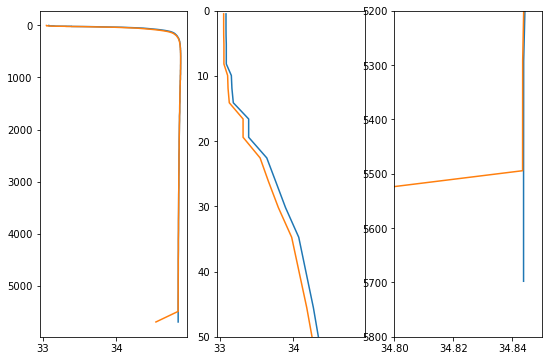

In [29]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(dss.SALT.sel(x=1050, y=383), mesh.nav_lev)
    axis.plot(dss.SALT.sel(x=1051, y=383), mesh.nav_lev)

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)
## temperature looks normal

(5800.0, 5200.0)

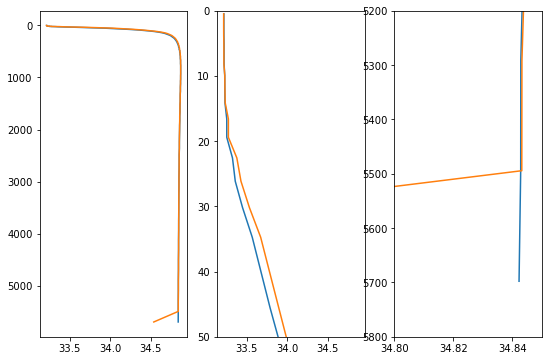

In [34]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(dss.SALT.sel(x=1050, y=411), mesh.nav_lev)
    axis.plot(dss.SALT.sel(x=1051, y=408), mesh.nav_lev)

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)
## temperature looks normal

salinity = 34.541 at depth level > 110 (fresher water underneath saltier is causing the instability), initial condition profiles also look sort of steppy which doesn't quite seem right, probably because of my vertical interpolation method. Reconsider?
--> consider using https://xgcm.readthedocs.io/en/latest/transform.html instead for vertical interpolation
or especially for boundary conditions, could consider interpolating with cf along slices of x, z 

First, test issue with initial conditions at the bottom and figure out whether it is because of:
- copying the bottom grid cell over in step just after vertical interpolation
- ocean_fill
- or the last step where I fill any remaining empty cells (the cells that are filled are 318, 1350; 318, 1351)
  
by looking at the vertical-interp output netcdf and viewing the profiles at the problem grid location

Then, fix the vertical interpolation method to be properly conservative.

In [3]:
def plot_bottom(dss, depths, title=''):

    fig, ax = plt.subplots(1,2, figsize=(6,6))
    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.plot(dss.SALT.sel(x=1050, y=383), depths)
        axis.plot(dss.SALT.sel(x=1051, y=383), depths)
    
    ax[1].set_xlim(34.5,35.2)
    ax[1].set_ylim(5800,5200)
    fig.suptitle(f'{title}')

    return fig, ax

In [4]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025-filledlakes.nc')

In [6]:
# no ocean fill, no copying over of grid cell:
ds1 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-test-vertical-interp.nc')
# with ocean fill, no copying over of grid cell:
ds2 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-test2-initial-conditions.nc')
# with ocean fill, fill_val=34.85, no copying over of grid cell:
# ds3 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-test3-initial-conditions.nc')
# with ocean fill and copying over of grid cell:
ds4 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-test4-initial-conditions.nc')

In [ ]:
fig, ax = plot_bottom(ds1, mesh.nav_lev, title='No ocean fill, no bottom copy')

In [ ]:
fig, ax = plot_bottom(ds2, mesh.nav_lev, title='With ocean fill, no bottom copy, fill value is mean')

In [ ]:
fig, ax = plot_bottom(ds3, mesh.nav_lev, title='With ocean fill, no bottom copy, fill value is 34.85')
ax[1].set_xlim(34.5,34.65)

(<Figure size 432x432 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

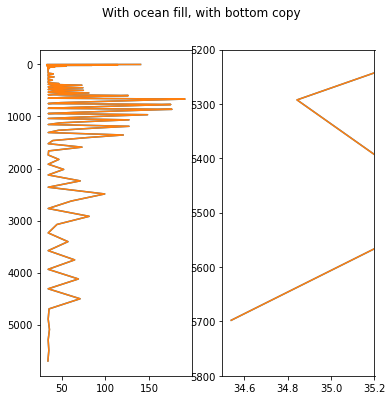

In [8]:
plot_bottom(ds4, mesh.nav_lev, title='With ocean fill, with bottom copy')

Next, improve the vertical interpolation

In [57]:
# Try vertical interpolation with xgcm: https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-transformation

# Find vertical cell edges
SOSE_coord      = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc')
SOSE_coord['Z'] = abs(SOSE_coord['Z'])
SOSE_coord      = SOSE_coord.rename({'Z':'z'})
(z_top_edge, z_centres, z_bot_edge) = vertical_edges(SOSE_coord, mtype='SOSE')

# step (1) --- make variable into an extensive (volume-weighted) property:
dst = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-olddomain-horizontal-interp.nc')
T2d = dst.copy()
T2d['SALT'] = dst.SALT*SOSE_coord.drF
T2d = T2d.assign_coords({'zc': np.insert(z_bot_edge[:,0,0], 0, 0., axis=0)})

# step (2) --- recreate the grid object with a stagg~ered `center`/`outer` coordinate layout
grid = Grid(T2d, coords={'Z':{'center':'z', 'outer':'zc'}}, periodic=False)
# # grid_top_edge

# step(3) --- interpolate salt to outer coordinate of grid object
T2d['salt_outer'] = grid.interp(T2d.SALT, 'Z', boundary='fill')

# step (4) --- transform the data using the conservative method.
nemo_depths_target = mesh.nav_lev.values

# and transform
transformed_cons = grid.transform(T2d.SALT, 'Z', nemo_depths_target, method='conservative')#, target_data=T2d.salt_outer)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [5]:
# new_ds = (transformed_cons).to_dataset()
new_ds = (transformed_cons/ np.diff(nemo_depths_target)).to_dataset()

In [6]:
print(np.nansum(transformed_cons.sel(x=1050, y=383)))
print(np.nansum(T2d['SALT'].sel(x=1050, y=383)))

191418.39623310522
195111.56460502028


(200.0, 0.0)

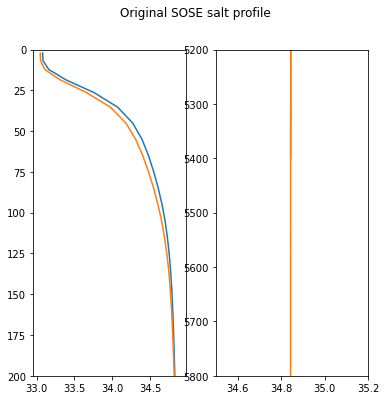

In [57]:
fig, ax = plot_bottom(dst, z_centres[:,0,0], title='Original SOSE salt profile')
ax[0].set_ylim(200,0)

(200.0, 0.0)

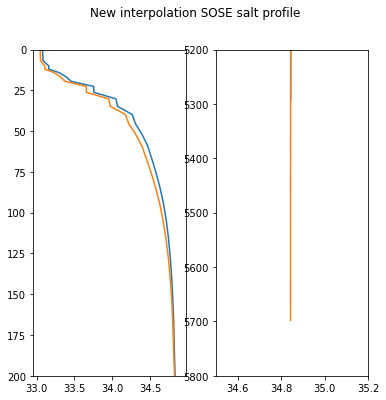

In [56]:
fig, ax = plot_bottom(new_ds, nemo_depths_target[:-1], title='New interpolation SOSE salt profile')
ax[0].set_ylim(200,0)

Try a simple scipy vertical 1d interpolation instead:

In [7]:
from scipy.interpolate import interp1d

In [8]:
f = interp1d(SOSE_coord.z, dst.SALT.values, axis=0, fill_value='extrapolate')
ynew = f(mesh.nav_lev.values)  
# plt.plot(x, y, 'o', xnew, ynew, '-')
# plt.show()

In [14]:
print(np.nansum(ynew[:,383,1050]*mesh.e3t_0.isel(time_counter=0, y=383, x=1050).values))
print(np.nansum(T2d['SALT'].sel(x=1050, y=383)))

187908.55550413116
195111.56460502028


(5800.0, 5200.0)

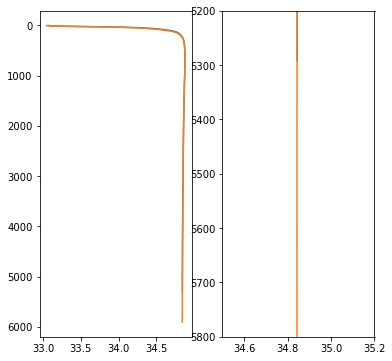

In [16]:
fig, ax = plt.subplots(1,2, figsize=(6,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(ynew[:,383,1050], mesh.nav_lev.values)
    axis.plot(ynew[:,383,1051], mesh.nav_lev.values)
        
ax[1].set_xlim(34.5,35.2)
ax[1].set_ylim(5800,5200)

### New domain 1ts based debugging

Time step size: 100 s

Error region:
```
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 60 |ssh| max   4.662     at i j    340 395     MPI rank 568
 kt 60 |U|   max   10.06     at i j k 1050 383 120 MPI rank 596
 kt 60 Sal   min   25.86     at i j k 1052 406 120 MPI rank 655
 kt 60 Sal   max   35.36     at i j k  362 220  33 MPI rank 146
```

In [ ]:
folder_1ts = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability-1ts/'

In [4]:
folder_1ts = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability-1ts/'
dfT = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_T_19790101010640-19790101013959.nc')
# dfU = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_U_19790101010640-19790101013959.nc')
# dfV = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_V_19790101010640-19790101013959.nc')
# dfW = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_W_19790101010640-19790101013959.nc')

### New domain:

In [29]:
# fill NaN and small values in new initial conditions with zeros or 10
IC_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/'
st        = xr.open_dataset(f'{IC_folder}SOSE-THETA-initial-conditions-20240123.nc')
ss        = xr.open_dataset(f'{IC_folder}SOSE-SALT-initial-conditions-20240123.nc')
st_new    = st.THETA.values[np.newaxis, ...]
ss_new    = ss.SALT.values[np.newaxis, ...]
# st_new[np.isnan(st_new)] =  0 #9999
# ss_new[np.isnan(ss_new)] =  10 #9999
# ss_new[ss_new==0]        =  10 #9999
# ss_new[0,-1,:,:]         =  ss_new[0,-2,:,:]
st_new[np.isnan(st_new)] =  9999
ss_new[np.isnan(ss_new)] =  9999
ss_new[ss_new==0]        =  9999
st_new[(nemo_mask_ds.tmask.values == 0)] = 0
ss_new[(nemo_mask_ds.tmask.values == 0)] = 0

stn             = st.drop_vars(['THETA'])
stn['votemper'] = ('time_counter','deptht','y','x'), st_new
stn['vosaline'] = ('time_counter','deptht','y','x'), ss_new
stn             = stn.assign_coords({'time_counter':xr.open_dataset(f'{IC_folder}istate_TS.nc').time_counter})
# stn.to_netcdf(f'{IC_folder}SOSE_istate_TS_20240123.nc', unlimited_dims='time_counter')

In [9]:
SOSE_interp   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-test6-vertical-interp.nc')
nemo_mask_ds  = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240123-filledlakes.nc')

# SOSE_extended = fill_ocean(SOSE_interp, variable, nemo_mask_ds, dim=dimension, niter=num_iter, fill_val=fill_value)
# def fill_ocean(input_dataset, variable, nemo_mask, missing_val=-9999, fill_val=np.nan, niter=100, dim='3D'):

nemo_ocn = (nemo_mask_ds.tmask.isel(time_counter=0).values == 1)
# Fill gaps in source dataset with nearest neighbour
src_to_fill = xr.where(np.isnan(SOSE_interp.SALT.values)*nemo_ocn, -9999, SOSE_interp.SALT.values)

# var_filled  = extend_into_mask(src_to_fill, missing_val=missing_val, fill_val=fill_val, use_2d=use_2d, use_3d=use_3d, num_iters=niter) 

# Remove any points with values that are actually in the land
#     var_filled = xr.where(~nemo_ocn, np.nan, var_filled)
    
#     if dim=='3D':   input_dataset[variable] = (('z','y','x'), var_filled)

In [36]:
nemo_mask_ds.tmask.isel(time_counter=0, nav_lev=120)

<xarray.DataArray 'tmask' (y: 453, x: 1440)>
[652320 values with dtype=int8]
Coordinates:
    nav_lev       float32 5.902e+03
    time_counter  float32 0.0
Dimensions without coordinates: y, x

In [41]:
nemo_mask_ds.nav_lev[-1]

<xarray.DataArray 'nav_lev' ()>
array(5902.4194, dtype=float32)
Coordinates:
    nav_lev  float32 5.902e+03

In [39]:
nemo_ocn[:,394,1054]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False])

In [52]:
src_to_fill[:,394,1054]

array([   33.11330993,    33.11330993,    33.11330993,    33.11383772,
          33.1157839 ,    33.1157839 ,    33.1157839 ,    33.13089279,
          33.13259971,    33.13967549,    33.21795705,    33.21795705,
          33.3880647 ,    33.47096791,    33.60348268,    33.78014625,
          33.89310268,    34.01964682,    34.14945957,    34.22781579,
          34.31382237,    34.40169424,    34.48066055,    34.54961714,
          34.61373072,    34.67160223,    34.71423993,    34.7473828 ,
          34.77022786,    34.78538994,    34.79923614,    34.81210976,
          34.82015449,    34.82774049,    34.83604306,    34.8422323 ,
          34.84695489,    34.85129208,    34.85531625,    34.85954711,
          34.86021357,    34.86472962,    34.86474904,    34.86731967,
          34.86867993,    34.86867993,    34.87147427,    34.87177101,
          34.87177101,    34.8736936 ,    34.87398054,    34.87398054,
          34.87513786,    34.87533532,    34.87533532,    34.87579261,
      

In [21]:
SOSE_interp.SALT.values[:,394,1054]

array([33.11330993, 33.11330993, 33.11330993, 33.11383772, 33.1157839 ,
       33.1157839 , 33.1157839 , 33.13089279, 33.13259971, 33.13967549,
       33.21795705, 33.21795705, 33.3880647 , 33.47096791, 33.60348268,
       33.78014625, 33.89310268, 34.01964682, 34.14945957, 34.22781579,
       34.31382237, 34.40169424, 34.48066055, 34.54961714, 34.61373072,
       34.67160223, 34.71423993, 34.7473828 , 34.77022786, 34.78538994,
       34.79923614, 34.81210976, 34.82015449, 34.82774049, 34.83604306,
       34.8422323 , 34.84695489, 34.85129208, 34.85531625, 34.85954711,
       34.86021357, 34.86472962, 34.86474904, 34.86731967, 34.86867993,
       34.86867993, 34.87147427, 34.87177101, 34.87177101, 34.8736936 ,
       34.87398054, 34.87398054, 34.87513786, 34.87533532, 34.87533532,
       34.87579261, 34.87601047, 34.87601047, 34.87601047, 34.87603607,
       34.87607376, 34.87607376, 34.87607376, 34.87607376, 34.87607376,
       34.87570975, 34.87547835, 34.87547835, 34.87547835, 34.87

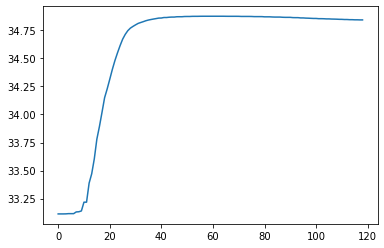

In [20]:
plt.plot(SOSE_interp.SALT.values[:,394,1054])

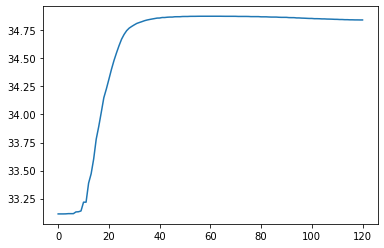

In [53]:
plt.plot(ss_new[0,:,394,1054])

In [89]:
# fill NaN and small values in new initial conditions with zeros
sic     = xr.open_dataset(f'{IC_folder}SOSE-SeaIceArea-initial-conditions-20240123.nc')
sit     = xr.open_dataset(f'{IC_folder}SOSE-SeaIceHeff-initial-conditions-20240123.nc')
snt     = xr.open_dataset(f'{IC_folder}SOSE-SeaIceHsnow-initial-conditions-20240123.nc')
sic_new = sic.SIarea.values[np.newaxis, ...]
sit_new = sit.SIheff.values[np.newaxis, ...]
snt_new = snt.SIhsnow.values[np.newaxis, ...]
sic_new[np.isnan(sic_new)] = 0
sit_new[np.isnan(sit_new)] = 0
snt_new[np.isnan(snt_new)] = 0
sic_new[sic_new < 0.001]   = 0
sit_new[sit_new < 0.001]   = 0
snt_new[snt_new < 0.001]   = 0

sin           = st.drop_vars(['THETA'])
sin['siconc'] = ('time_counter','y','x'), sic_new
sin['sithic'] = ('time_counter','y','x'), sit_new
sin['snthic'] = ('time_counter','y','x'), snt_new
sin           = sin.assign_coords({'time_counter':xr.open_dataset(f'{IC_folder}istate_sea_ice.nc').time_counter})
sin.to_netcdf(f'{IC_folder}SOSE_istate_sea_ice_20240123.nc', unlimited_dims='time_counter')